# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa

from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error as rms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [115]:
# Run this code:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [116]:
# Your code here:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [117]:
# Your code here:
sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [118]:
# Your code here:
sensor.shape

(1751, 12)

**Rows ==> 1751  
Columns ==> 12**

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [119]:
# Your code here:
DateTimeIndex = pd.date_range(start ='1-1-2018 00:00:00',
                                 end ='1-05-2018 00:29:10',periods=len(sensor))

Assign the time series index to the dataframe's index.

In [120]:
sensor = sensor.set_index(DateTimeIndex)
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00.000000000,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:03:18.485714285,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:06:36.971428571,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:09:55.457142857,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:13:13.942857142,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

<Figure size 1440x1080 with 0 Axes>

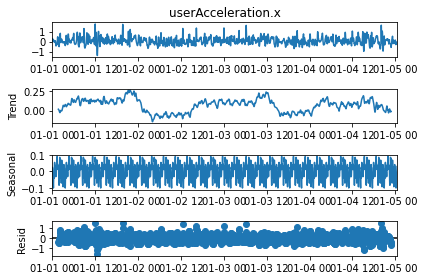

In [121]:
# Your code here:REVISAR ESTO PARA HACER LA GRAFICA MAS GRANDE
plt.figure(figsize = (20,15))
descompose = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], period = 60)
descompose.plot()
plt.show()

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

<Figure size 1440x1080 with 0 Axes>

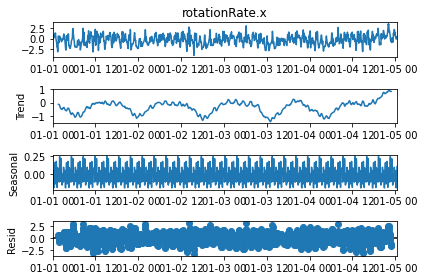

In [122]:
plt.figure(figsize = (20,15))
descompose = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], period = 60)
descompose.plot()
plt.show()

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

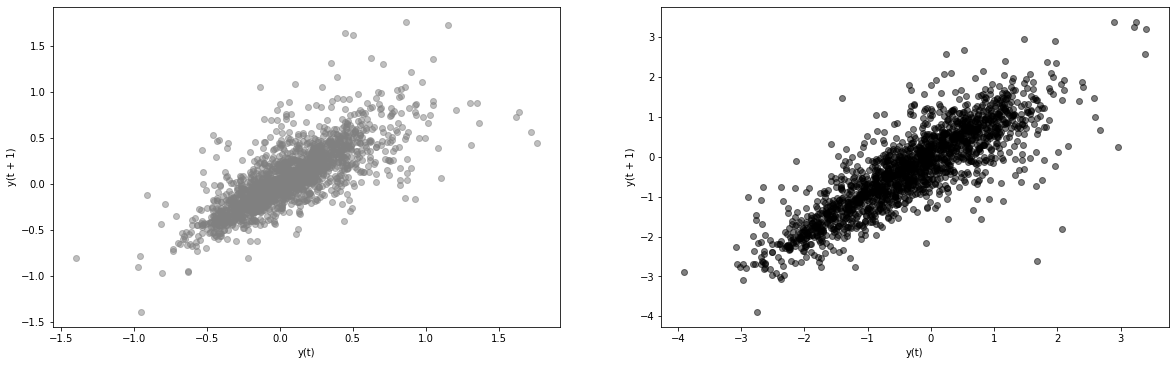

In [123]:
plt.figure(figsize = (20,20))
plt.subplot(321)
lag_plot(sensor["userAcceleration.x"],c = "grey", alpha=0.5)

plt.subplot(322)
lag_plot(sensor["rotationRate.x"], c = "black", alpha=0.5)

What are your conclusions from both visualizations?

With lagplot, we can check whether there is a possible correlation between our data this period(i.e. second, month, year) and the previous period. 
In the case of lag plots the complete correlation is a perfect diagonal. In our case it is not like that, so we could say that our data show a moderate autocorrelation. If more data is concentrated on the diagonal in lag plot, it means there is a strong autocorrelation. It's important to note that both plots indicate positive correlation. 
In addition, despite the fact that they present some dispersion in the data, it seems that the data of the variable X are a little more adjusted to the diagonal and therefore there is more autocorrelation.

[InfoLagPlot1](https://www.geeksforgeeks.org/lag-plots/)  
[InfoLagPlot2](https://www.statisticshowto.com/lag-plot/)

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

>**adf, pvalue, usedlag, nobs, critical_values, icbest ==> Dickey Fuller results order**

In [124]:
# Your code here:
difu_acceleration = adfuller(sensor["userAcceleration.x"])
difu_acceleration

(-17.957994086169762,
 2.823439483037483e-30,
 4,
 1746,
 {'1%': -3.434100824760071,
  '5%': -2.863196780129223,
  '10%': -2.5676520210882936},
 -727.6140124402791)

In [125]:
difu_rotation = adfuller(sensor["rotationRate.x"])
difu_rotation

(-5.2698606250864195,
 6.320230335912249e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '5%': -2.863216966926812,
  '10%': -2.567662770090317},
 2619.6049719981947)

What are your conclusions from this test?

From the Dickey Fuller test results we can look at two things:

>1- If adf > critical_values we cannot reject the null hypothesis (the time series is not stationary) ==> NON-STATIONARY DATA

>2- pvalue> 0.05 we cannot reject null hypothesis ==> NON-STATIONARY DATA


Therefore:

`userAcceleration.x`: the adf is less than the critical values and p-value < 0.05, we reject the null hypothesis H0 and **it is stationary**

`rotationRate.x`: the adf is less than the critical values p-value < 0.05, we reject the null hypothesis H0 and **it is stationary**

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

ARMA models have two parameters:
>1- **AR(p)** ==> Partial autocorrelation function 

>2- **MA(q)** ==> Autocorrelation function

Before executing the models I am going to plot each of these functions to get the parameters:

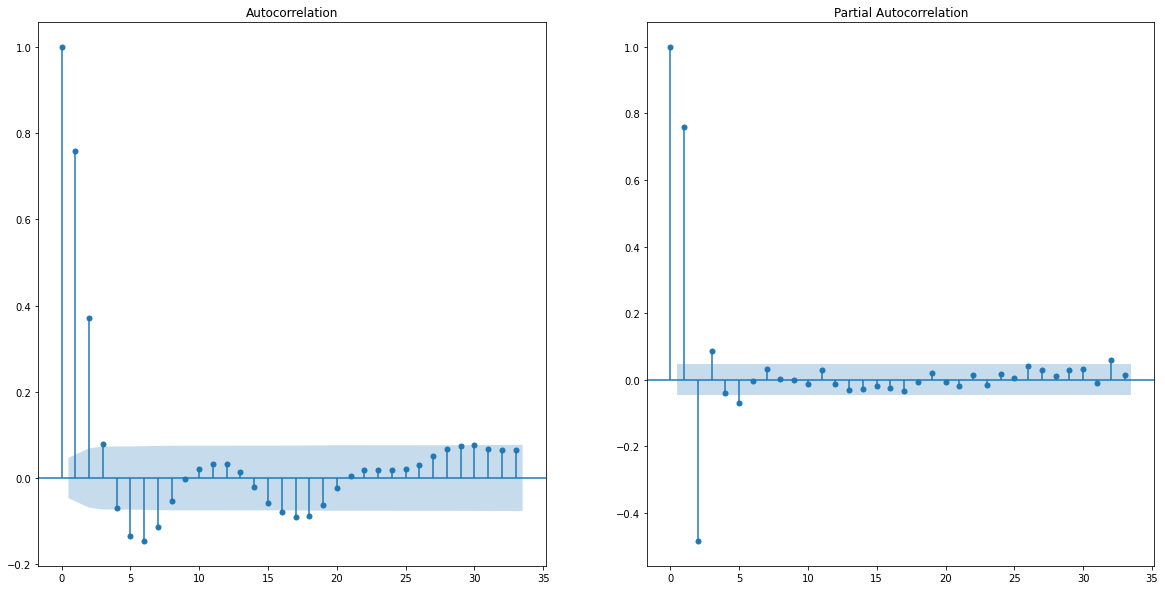

In [126]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plot_acf(sensor["userAcceleration.x"],  ax=ax[0]);
plot_pacf(sensor["userAcceleration.x"], ax=ax[1]);

In [127]:
test_data = sensor["rotationRate.x"][-10:]
train_data = sensor["rotationRate.x"][:-10]

In [ ]:
# Your code here:
orders = (2,1)
model = tsa.ARMA(sensor['userAcceleration.x'], order = orders)
model;

In [129]:
arma = model.fit()
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:     userAcceleration.x   No. Observations:                 1751
Model:                     ARMA(2, 1)   Log Likelihood                 379.399
Method:                       css-mle   S.D. of innovations              0.195
Date:                Thu, 18 Feb 2021   AIC                           -748.798
Time:                        22:27:56   BIC                           -721.458
Sample:                             0   HQIC                          -738.692
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0625      0.014      4.436      0.000       0.035       0.090
ar.L1.userAcceleration.x     0.9888      0.044     22.726      0.000       0.904       1.

> **coef** ==> the AR(L1) model equals  0.9888, can I interpret it as that for every 1 unit increase in Xt-1, Xt would increase by  0.9888, and the same for AR(L2).  
> **std err** ==> standard error relates to an estimate of the error of the predicted value.   
> **z** ==> the standardized value of the coefficient values.  
> **0.025 0.975]** ==> conf interval is also no new information and is the coefficient value +/- a certain number of the standard error.

[ArmaInterpretation1](https://stats.stackexchange.com/questions/290718/arma-coefficient-interpretation)  
[ArmaInterpretation2](http://halweb.uc3m.es/esp/Personal/personas/amalonso/esp/tsa.htm)

In [139]:
#make predictions
predictions = arma.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

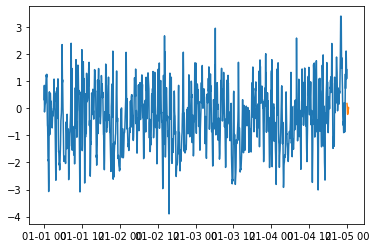

In [140]:
plt.plot(train_data)
plt.plot(predictions)

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [146]:
#comparing the observed vs predicted data
compare = pd.DataFrame({'observed':test_data, 'predicted':predictions})
compare

,observed,predicted
2018-01-04 23:59:23.628571428,1.065054,0.172776
2018-01-05 00:02:42.114285714,0.497726,0.115159
2018-01-05 00:06:00.600000000,0.426906,-0.008270
2018-01-05 00:09:19.085714285,0.414523,-0.186762
2018-01-05 00:12:37.571428571,0.027461,-0.229210
2018-01-05 00:15:56.057142857,-0.123211,-0.136440
2018-01-05 00:19:14.542857142,-0.057641,-0.162658
2018-01-05 00:22:33.028571428,0.343238,0.035719
2018-01-05 00:25:51.514285714,0.470144,-0.043530
2018-01-05 00:29:10.000000000,0.291873,0.008415


In [153]:
rmse = rms(compare['observed'], compare['predicted'], squared=False)

In [155]:
print(f'The Root Mean Square Error between observed and predicted is {rmse}')

The Root Mean Square Error between observed and predicted is 0.4482520058150508


RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. **Lower values of RMSE indicate better fit.** RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

[RMSE](https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/#:~:text=As%20the%20square%20root%20of,of%20RMSE%20indicate%20better%20fit.)